In [ ]:
!pip install librosa soundfile numpy pandas scikit-learn keras tensorflow matplotlib
!pip install numpy matplotlib scikit-learn tensorflow
!pip install librosa resampy soundfile
!pip install resampy --upgrade --quiet

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
import librosa
import numpy as np
import os

def extract(file_path, n_mfcc=40, max_len=174):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # Padding or truncating to a fixed length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs

In [ ]:
import glob

# Show the first 5 matched files
wav_files = glob.glob("/kaggle/input/ravdess-emotional-speech-audio/Actor_*/*.wav")
print("Total WAV files found:", len(wav_files))
print("First 3 files:", wav_files[:3])

Total WAV files found: 1440
First 3 files: ['/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav', '/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav', '/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav']


In [ ]:
test_file = wav_files[0]
print("Testing file:", test_file)
mfcc = extract_mfcc(test_file)
print("MFCC shape:", mfcc.shape)

Testing file: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
MFCC shape: (40, 174)


In [ ]:
data = []
labels = []

emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

for file_path in wav_files:
    file_name = file_path.split("/")[-1]
    parts = file_name.split("-")

    if len(parts) > 2:
        emotion_code = parts[2]
        emotion = emotions.get(emotion_code)

        if emotion:
            try:
                mfcc = extract_mfcc(file_path)
                data.append(mfcc)
                labels.append(emotion)
            except Exception as e:
                print(f"⚠️ Skipped file {file_name} due to error: {e}")

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.array(data)[..., np.newaxis]  # Add channel dimension for CNN
print("✅ Feature shape:", X.shape)

le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))
print("✅ Label shape:", y.shape)
print("✅ Classes:", le.classes_)

✅ Feature shape: (1440, 40, 174, 1)
✅ Label shape: (1440, 8)
✅ Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,epochs=30,batch_size=32,validation_data=(X_test, y_test))

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.1547 - loss: 23.0633 - val_accuracy: 0.1424 - val_loss: 2.0963
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.1706 - loss: 2.0599 - val_accuracy: 0.1875 - val_loss: 2.0547
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.1828 - loss: 2.0016 - val_accuracy: 0.2326 - val_loss: 1.9756
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.2137 - loss: 1.9733 - val_accuracy: 0.2431 - val_loss: 1.8871
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.2799 - loss: 1.8891 - val_accuracy: 0.2674 - val_loss: 1.9104
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.3238 - loss: 1.7859 - val_accuracy: 0.3021 - val_loss: 1.8161
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.3255 - loss: 1.7304 - val_accuracy: 0.2812 - val_loss: 1.7328
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.4092 - loss: 1.5763 - val_accur

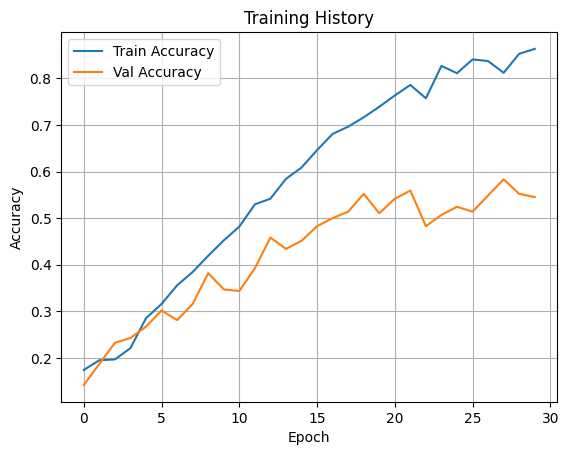

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Final Test: {test_acc:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5369 - loss: 1.4340
Final Test: 0.55


In [ ]:
model.save("emotion_recognition_model.h5")